# Import Libraries

In [1]:
# libraries that deal with grabbing from the .env file
from dotenv import load_dotenv
import os

# make url requests
import requests

# make DFs
import pandas as pd

# show images in notebook
from IPython.display import display, Image

import ast  # for safely parsing JSON strings in Python

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import requests

from ratelimit import limits, sleep_and_retry
import requests



# Setup stuff

In [2]:
# Remove the cached environment variable (if any)
os.environ.pop('riot_api_key', None)

# Reload the .env file
load_dotenv()

# Fetch the API key
api_key = os.environ.get('riot_api_key')

# Defining Functions

## Get Puuid

In [3]:
def get_puuid(summonerId=None, gameName=None, tagLine=None, region='americas'):
    """Gets the puuid from a summonerId or Riot_id and riot_tag
    
    Args:
        summonerId (str, optional): Summoner ID. Defaults to None.
        gameName (str, optional): Riot ID. Defaults to None.
        tagLine (str, optional): Riot Tag. Defaults to None.
        region (str, optional): Region. Defaults to 'americas'.
        
    Returns:
        str: puuid
    """
# using summonerID 
    if summonerId is not None:
        root_url = f'https://{region}.api.riotgames.com/'
        endpoint = 'lol/summoner/v4/summoners/'
        print(root_url+endpoint+summonerId+'?api_key='+api_key)
        response = requests.get(root_url+endpoint+summonerId+'?api_key='+api_key)

        return response.json()['puuid']
    else:
        #using gamename + tagline for example HGILLIS + NA1
        root_url = f'https://{region}.api.riotgames.com/'
        endpoint = f'riot/account/v1/accounts/by-riot-id/{gameName}/{tagLine}'

        response = requests.get(root_url+endpoint+'?api_key='+api_key)

        return response.json()['puuid']
    


## Get match history (list of game ids)

In [4]:
def get_match_history(region=None, puuid=None, start=0, count=48):
    root_url = f'https://{region}.api.riotgames.com/'
    endpoint = f'lol/match/v5/matches/by-puuid/{puuid}/ids'
    query_params = f'?start={start}&count={count}' #changing starting index (start) and number of matches retrieved (count)

    response = requests.get(root_url + endpoint + query_params + '&api_key=' + api_key)
    
    return response.json()


## get info for single game

In [5]:
def get_match_data_from_id(region = None, matchId = None):

    root_url = f'https://{region}.api.riotgames.com/'
    endpoint = f'lol/match/v5/matches/{matchId}'


    response = requests.get(root_url + endpoint + '?api_key=' + api_key)

    return response.json()

## Process match history

In [6]:


def process_match_json(match_json, puuid):
    ## Architecture
    # left side is my name, right side is riots name
    metadata = match_json['metadata']
    info = match_json['info']
    game_mode = info['gameMode']
    players = info['participants']
    participants = metadata['participants']
    teams = info['teams']
    player = players[participants.index(puuid)]
    perks = player['perks']
    stats = perks ['statPerks']
    styles = perks['styles']

    primary = styles[0]
    secondary = styles[1]

    match_id = metadata['matchId']


    game_creation = info['gameCreation']
    game_duration = info['gameDuration']
    game_start_timestamp = info['gameStartTimestamp']
    game_end_timestamp = info['gameEndTimestamp']
    patch = info['gameVersion']

    riot_id = player['riotIdGameName']
    riot_tag = player['riotIdTagline']
    summoner_id = player['summonerId']
    summoner_name = player['summonerName']

    win = player['win']

    champ_id = player['championId']
    champ_transform = player['championTransform']
    champ_level = player['champLevel']

    gold_earned = player['goldEarned']
    neutral_minions_killed = player['neutralMinionsKilled']
    total_minions_killed = player['totalMinionsKilled']

    kills = player['kills']
    deaths = player['deaths']
    assists = player['assists']
    first_blood = player['firstBloodKill']

    total_damage_dealt= player['totalDamageDealtToChampions']
    total_damage_shielded = player['totalDamageShieldedOnTeammates']
    total_damage_taken = player['totalDamageTaken']
    total_damage_healed = player['totalHealsOnTeammates']
    total_minions_killed = player['totalMinionsKilled']
    total_time_cc_dealt = player['totalTimeCCDealt']

    early_surrender = player['gameEndedInEarlySurrender']
    surrender = player['gameEndedInSurrender']

    item0 = player['item0']
    item1 = player['item1']
    item2 = player['item2']
    item3 = player['item3']
    item4 = player['item4']
    item5 = player['item5']
    item6 = player['item6']

    summoner_1_id = player['summoner1Id']
    summoner_2_id = player['summoner2Id']


    wards_placed = player['wardsPlaced']
    vision_score = player['visionScore']







    defense = stats['defense']
    flex = stats['flex']
    offense = stats['offense']


    primary_style = primary['style']
    secondary_style = primary['style']

    primary_keystone = primary['selections'][0]['perk']
    primary_perk_1 = primary['selections'][1]['perk']
    primary_perk_2 = primary['selections'][2]['perk']
    primary_perk_3 = primary['selections'][3]['perk']

    secondary_perk_1 = secondary['selections'][0]['perk']
    secondary_perk_2 = secondary['selections'][1]['perk']


    objectives_stolen = player['objectivesStolen']
    objectives_stolen_assists = player['objectivesStolenAssists']

    ##what is this?
    detector_wars_placed = player['detectorWardsPlaced']
    vision_wards_bought = player['visionWardsBoughtInGame']
    role = player['role']

    damage_dealt_to_buildings = player['damageDealtToBuildings']
    damage_dealt_to_objectives = player['damageDealtToObjectives']
    damage_dealt_to_turrets = player['damageDealtToTurrets']
    game_ended_in_surrender = player['gameEndedInSurrender']
    gold_earned = player['goldEarned']
    individual_position = player['individualPosition']
    inhibitor_takedowns = player['inhibitorTakedowns']
    largest_killing_spree = player['largestKillingSpree']
    largest_multi_kill = player['largestMultiKill']
    total_damage_shielded_on_teammates = player['totalDamageShieldedOnTeammates']
    total_heals_on_teammates = player['totalHealsOnTeammates']
    total_minions_killed = player['totalMinionsKilled']
    vision_score = player['visionScore']

    matchDF = pd.DataFrame({
        'match_id': [match_id],
        'game_mode': [game_mode],
        'participants': [participants],
        'game_creation': [game_creation],
        'game_duration': [game_duration],
        'game_start_timestamp': [game_start_timestamp],
        'game_end_timestamp': [game_end_timestamp],
        'patch': [patch],
        'puuid': [puuid],
        'riot_id': [riot_id],
        'riot_tag': [riot_tag],
        'summoner_id': [summoner_id],
        'summoner_name': [summoner_name],
        'win': [win],
        'champion': [champ_id],
        'champion_transform': [champ_transform],
        'champion_level': [champ_level],
        'kills': [kills],
        'deaths': [deaths],
        'assists': [assists],
        'summoner1_id': [summoner_1_id],
        'summoner2_id': [summoner_2_id],
        'gold_earned': [gold_earned],
        'total_minions_killed': [total_minions_killed],
        'total_neutral_minions_killed': [neutral_minions_killed],
        'early_surrender': [early_surrender],
        'surrender': [surrender],
        'first_blood': [first_blood],
        'objectives_stolen': [objectives_stolen],
        'objectives_stolen_assists': [objectives_stolen_assists],
        'total_damage_dealt_champions': [total_damage_dealt],
        'total_damage_taken': [total_damage_taken],
        'total_damage_shielded_teammates': [total_damage_shielded],
        'total_time_crowd_controlled': [total_time_cc_dealt],
        'vision_score': [vision_score],
        'wards_placed': [wards_placed],
        'item0': [item0],
        'item1': [item1],
        'item2': [item2],
        'item3': [item3],
        'item4': [item4],
        'item5': [item5],
        'item6': [item6],
        'perk_keystone': [primary_keystone],
        'perk_primary_row_1': [primary_perk_1],
        'perk_primary_row_2': [primary_perk_2],
        'perk_primary_row_3': [primary_perk_3],
        'perk_secondary_row_1': [secondary_perk_1],
        'perk_secondary_row_2': [secondary_perk_2],
        'perk_primary_style': [primary_style],
        'perk_secondary_style': [secondary_style],
        'perk_shard_defense': [defense],
        'perk_shard_flex': [flex],
        'perk_shard_offense': [offense],
        'damage_dealt_to_buildings': [damage_dealt_to_buildings],
        'damage_dealt_to_objectives': [damage_dealt_to_objectives],
        'damage_dealt_to_turrets': [damage_dealt_to_turrets],
        'game_ended_in_surrender': [game_ended_in_surrender],
        'individual_position': [individual_position],
        'inhibitor_takedowns': [inhibitor_takedowns],
        'largest_killing_spree': [largest_killing_spree],
        'largest_multi_kill': [largest_multi_kill],
        'total_damage_shielded_on_teammates': [total_damage_shielded_on_teammates],
        'total_heals_on_teammates': [total_heals_on_teammates],
        'total_minions_killed': [total_minions_killed],
        'vision_score': [vision_score],
    })


    return matchDF


## go from json to english

In [7]:

def json_extract(obj, key):
    arr = []
    
    def extract(obj, arr, key):
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k == key:
                    arr.append(v)
                elif isinstance(v, (dict, list)):
                    extract(v, arr, key)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    values = extract(obj, arr, key)
    return values


# Community Dragon

In [8]:
# keys to go from numbers to actual names

perk = 'https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/perks.json'
perk_styles = 'https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/perkstyles.json'
champ = 'https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/champion-summary.json'
item = 'https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/items.json'

perk_json = requests.get(perk).json()
perk_styles_json = requests.get(perk_styles).json()
champ_json = requests.get(champ).json()
item_json = requests.get(item).json()

In [9]:
# code to replace all of the perk numbers with the actual perks

perk_ids = json_extract(perk_json, 'id')
perk_names = json_extract(perk_json, 'name')

perk_dict = dict(map(lambda i, j : (int(i),j), perk_ids, perk_names))

perk_styles_ids = json_extract(perk_styles_json, 'id')
perk_styles_names = json_extract(perk_styles_json, 'name')

perk_styles_dict = dict(map(lambda i, j : (int(i),j), perk_styles_ids, perk_styles_names))

In [10]:
# code to replace all of the champion numbers with the actual champions
champ_ids = json_extract(champ_json, 'id')
champ_names = json_extract(champ_json, 'name')

# Assuming champ_json is a list of dictionaries with each dictionary containing 'id' and 'name'
champ_dict = {int(champ['id']): champ['name'] for champ in champ_json}



In [11]:
# code to replace all of the item numbers with the actual items
item_ids = json_extract(item_json, 'id')
item_names = json_extract(item_json, 'name')

# Assuming champ_json is a list of dictionaries with each dictionary containing 'id' and 'name'
item_dict = {int(item['id']): item['name'] for item in item_json}


# Get player names

In [12]:
# input username, region code here, asking for user input

# Prompt user for input
gameNameOne = input("Enter your summoner: ")


# Prompt user for input with a default value
tagLineOne = input("Enter tagline (default: NA1): ")

# Use default value if input is empty
tagLineOne = tagLineOne if tagLineOne.strip() else "NA1"

print(gameNameOne, tagLineOne)






# input username, region code here, asking for user input

# Prompt user for input of second player
gameNameTwo = input("Enter your friends summoner: ")


# Prompt user for input with a default value
tagLineTwo = input("Enter tagline (default: NA1): ")

# Use default value if input is empty
tagLineTwo = tagLineTwo if tagLineTwo.strip() else "NA1"

print(gameNameTwo, tagLineTwo)



hgillis NA1
copy magic


# Get both players PUUIDs

In [13]:
# get player 1 puuid
puuidOne = get_puuid(gameName=gameNameOne, tagLine=tagLineOne)

# get player 2 puuid
puuidTwo = get_puuid(gameName=gameNameTwo, tagLine=tagLineTwo)

print(puuidOne)
print(puuidTwo)

e6gR3aKcGDT6MoaI4Jett0L7kxScvYTWkjzDfhNyp3mwYzL0MsLmgBJ_wH30Twq9JLO0u7Sxx9si1w
G2SBG1Ha5P1IVEnhd1Tr0GD8Pj41YGKKvXR-3RuHcXkWMGGRwXKoMJkBV41Y-BKZbIq9jVNbC4MG7g


# Get both players match histories

In [14]:
# Get match IDs for the first game
match_idsOne = get_match_history(region='americas', puuid=puuidOne)

# Initialize an empty DataFrame for the first game
matchHistoryDfOne = pd.DataFrame()

# Populate the DataFrame with match data for the first game
for match_id in match_idsOne:
    gameone = get_match_data_from_id(region='americas', matchId=match_id)
    matchDFOne = process_match_json(gameone, puuid=puuidOne)
    matchHistoryDfOne = pd.concat([matchHistoryDfOne, matchDFOne])

# Get match IDs for the second game
match_idsTwo = get_match_history(region='americas', puuid=puuidTwo)

# Initialize an empty DataFrame for the second game
matchHistoryDfTwo = pd.DataFrame()

# Populate the DataFrame with match data for the second game
for match_id in match_idsTwo:
    gametwo = get_match_data_from_id(region='americas', matchId=match_id)
    matchDFTwo = process_match_json(gametwo, puuid=puuidTwo)
    matchHistoryDfTwo = pd.concat([matchHistoryDfTwo, matchDFTwo])

# Now, `matchHistoryDfOne` and `matchHistoryDfTwo` are isolated and contain data for different game names


In [15]:
matchHistoryDfOne


,match_id,game_mode,participants,game_creation,game_duration,game_start_timestamp,game_end_timestamp,patch,puuid,riot_id,...,damage_dealt_to_buildings,damage_dealt_to_objectives,damage_dealt_to_turrets,game_ended_in_surrender,individual_position,inhibitor_takedowns,largest_killing_spree,largest_multi_kill,total_damage_shielded_on_teammates,total_heals_on_teammates
0,NA1_5185600011,CLASSIC,[-aUURUm0BjDvqYT59D6U5iB6fnlOPTsOF67yUCQRc1p_v...,1734573265099,1711,1734573347600,1734575059260,14.24.644.2327,e6gR3aKcGDT6MoaI4Jett0L7kxScvYTWkjzDfhNyp3mwYz...,HGILLIS,...,607,1354,607,False,UTILITY,0,2,1,2189,2588
0,NA1_5185562835,CLASSIC,[8YUtmkARepdVGeZsdOzPeQAQ8FQuoEKqsrEDX2Y2LRKA3...,1734570716620,2203,1734570738656,1734572942050,14.24.644.2327,e6gR3aKcGDT6MoaI4Jett0L7kxScvYTWkjzDfhNyp3mwYz...,HGILLIS,...,461,1410,461,False,UTILITY,0,0,1,6059,5990
0,NA1_5185539086,ARAM,[ERB-v3SRfHRc29Tvdca41BjAtzT-VmToNRmVY33On5Kip...,1734569144358,1184,1734569243723,1734570428197,14.24.644.2327,e6gR3aKcGDT6MoaI4Jett0L7kxScvYTWkjzDfhNyp3mwYz...,HGILLIS,...,1421,1421,1421,True,Invalid,2,3,2,2172,0
0,NA1_5185026871,CLASSIC,[VDC-W0jElWySjw50yRhnnSdn3aqydQJBnxBmv8LrnVOTe...,1734499754015,1972,1734499781499,1734501753808,14.24.644.2327,e6gR3aKcGDT6MoaI4Jett0L7kxScvYTWkjzDfhNyp3mwYz...,HGILLIS,...,6196,45797,6196,False,JUNGLE,1,9,2,0,0
0,NA1_5184982618,CLASSIC,[VDC-W0jElWySjw50yRhnnSdn3aqydQJBnxBmv8LrnVOTe...,1734497182447,2309,1734497210384,1734499519782,14.24.644.2327,e6gR3aKcGDT6MoaI4Jett0L7kxScvYTWkjzDfhNyp3mwYz...,HGILLIS,...,5110,53132,5110,False,JUNGLE,0,2,1,0,0
0,NA1_5184961755,CLASSIC,[VDC-W0jElWySjw50yRhnnSdn3aqydQJBnxBmv8LrnVOTe...,1734495791967,913,1734495874215,1734496787601,14.24.644.2327,e6gR3aKcGDT6MoaI4Jett0L7kxScvYTWkjzDfhNyp3mwYz...,HGILLIS,...,0,12378,0,True,JUNGLE,0,5,2,0,0
0,NA1_5184839751,CLASSIC,[_gppYQbv_gI3nJ_wwLlfk1i_ecBrAHUIoN7rhUMjkdBPY...,1734488828340,2166,1734488880877,1734491046936,14.24.644.2327,e6gR3aKcGDT6MoaI4Jett0L7kxScvYTWkjzDfhNyp3mwYz...,HGILLIS,...,3900,9517,3900,True,TOP,0,0,1,0,1324
0,NA1_5184808493,CLASSIC,[A44_LYJRf3C9sUK-puqEv8Ol8e5RzIQ-RGSayxFUlPWUJ...,1734487042483,1453,1734487070854,1734488523990,14.24.644.2327,e6gR3aKcGDT6MoaI4Jett0L7kxScvYTWkjzDfhNyp3mwYz...,HGILLIS,...,2169,26757,2169,True,JUNGLE,0,0,0,4966,0
0,NA1_5184801910,CLASSIC,[cyvqZ9qmNAVRxbAsh9zsk389QVa-JGC7mkB6leGaucMmK...,1734486430890,124,1734486675564,1734486799879,14.24.644.2327,e6gR3aKcGDT6MoaI4Jett0L7kxScvYTWkjzDfhNyp3mwYz...,HGILLIS,...,0,0,0,False,JUNGLE,0,0,0,55,0
0,NA1_5183290141,CLASSIC,[VDC-W0jElWySjw50yRhnnSdn3aqydQJBnxBmv8LrnVOTe...,1734323501921,2187,1734323746573,1734325933833,14.24.643.5128,e6gR3aKcGDT6MoaI4Jett0L7kxScvYTWkjzDfhNyp3mwYz...,HGILLIS,...,2034,2135,2034,False,UTILITY,0,0,1,1835,2550


In [16]:
matchHistoryDfTwo

,match_id,game_mode,participants,game_creation,game_duration,game_start_timestamp,game_end_timestamp,patch,puuid,riot_id,...,damage_dealt_to_buildings,damage_dealt_to_objectives,damage_dealt_to_turrets,game_ended_in_surrender,individual_position,inhibitor_takedowns,largest_killing_spree,largest_multi_kill,total_damage_shielded_on_teammates,total_heals_on_teammates
0,NA1_5185600011,CLASSIC,[-aUURUm0BjDvqYT59D6U5iB6fnlOPTsOF67yUCQRc1p_v...,1734573265099,1711,1734573347600,1734575059260,14.24.644.2327,G2SBG1Ha5P1IVEnhd1Tr0GD8Pj41YGKKvXR-3RuHcXkWMG...,Copy,...,3402,5811,3402,False,BOTTOM,0,2,2,0,0
0,NA1_5185562835,CLASSIC,[8YUtmkARepdVGeZsdOzPeQAQ8FQuoEKqsrEDX2Y2LRKA3...,1734570716620,2203,1734570738656,1734572942050,14.24.644.2327,G2SBG1Ha5P1IVEnhd1Tr0GD8Pj41YGKKvXR-3RuHcXkWMG...,Copy,...,8406,34466,8406,False,BOTTOM,1,7,3,0,0
0,NA1_5185539086,ARAM,[ERB-v3SRfHRc29Tvdca41BjAtzT-VmToNRmVY33On5Kip...,1734569144358,1184,1734569243723,1734570428197,14.24.644.2327,G2SBG1Ha5P1IVEnhd1Tr0GD8Pj41YGKKvXR-3RuHcXkWMG...,Copy,...,1006,1006,1006,True,Invalid,1,3,3,2711,173
0,NA1_5183290141,CLASSIC,[VDC-W0jElWySjw50yRhnnSdn3aqydQJBnxBmv8LrnVOTe...,1734323501921,2187,1734323746573,1734325933833,14.24.643.5128,G2SBG1Ha5P1IVEnhd1Tr0GD8Pj41YGKKvXR-3RuHcXkWMG...,Copy,...,14250,19552,14250,False,BOTTOM,1,6,4,0,0
0,NA1_5183249627,CLASSIC,[VDC-W0jElWySjw50yRhnnSdn3aqydQJBnxBmv8LrnVOTe...,1734321321424,1858,1734321401751,1734323259816,14.24.643.5128,G2SBG1Ha5P1IVEnhd1Tr0GD8Pj41YGKKvXR-3RuHcXkWMG...,Copy,...,6919,36986,6919,True,BOTTOM,0,9,4,0,0
0,NA1_5183209013,ARAM,[XGpEtCqxAKACTISHM1_qbfQoJXUX_uHgNShMN3PpahJ5G...,1734319005353,1567,1734319040164,1734320607783,14.24.643.5128,G2SBG1Ha5P1IVEnhd1Tr0GD8Pj41YGKKvXR-3RuHcXkWMG...,Copy,...,6228,6228,6228,False,Invalid,3,6,3,0,0
0,NA1_5183170531,ARAM,[XGpEtCqxAKACTISHM1_qbfQoJXUX_uHgNShMN3PpahJ5G...,1734317220320,1562,1734317306223,1734318868260,14.24.643.5128,G2SBG1Ha5P1IVEnhd1Tr0GD8Pj41YGKKvXR-3RuHcXkWMG...,Copy,...,3753,3753,3753,False,Invalid,1,11,4,0,0
0,NA1_5183136676,ARAM,[3panZgR8yTTa7pHek2dpS1J0ZJZVjIr61ZYPP6pWjECRi...,1734315538157,850,1734315685920,1734316536430,14.24.643.5128,G2SBG1Ha5P1IVEnhd1Tr0GD8Pj41YGKKvXR-3RuHcXkWMG...,Copy,...,3186,3186,3186,False,Invalid,1,5,2,0,0
0,NA1_5182445564,CLASSIC,[7UsWBNAWsmRm6vDDJdD4GVWd-G0tVQXIDyLe9VcHOS6Mc...,1734244268658,1868,1734244352125,1734246220207,14.24.643.5128,G2SBG1Ha5P1IVEnhd1Tr0GD8Pj41YGKKvXR-3RuHcXkWMG...,Copy,...,12484,28860,12484,False,BOTTOM,1,8,4,0,0
0,NA1_5181444806,CLASSIC,[HAkyTRuz58CxB-RcAxzH8wjlwRZeAV5-H8A7jYDtrescA...,1734153465699,1733,1734153550843,1734155283741,14.24.643.5128,G2SBG1Ha5P1IVEnhd1Tr0GD8Pj41YGKKvXR-3RuHcXkWMG...,Copy,...,7413,9422,7413,False,BOTTOM,0,2,2,0,0


In [17]:
pd.options.display.max_columns = 100

matchHistoryDfOne.replace(perk_dict).replace(perk_styles_dict)

# Replace only the 'champion' column with the values from champ_dict
matchHistoryDfOne['champion'] = matchHistoryDfOne['champion'].replace(champ_dict)

#calculate loading screen time
matchHistoryDfOne['loadTime'] = (matchHistoryDfOne['game_start_timestamp'] - matchHistoryDfOne['game_creation']) / 1000

# replace the item columns with the the actual items names from the item_dict
matchHistoryDfOne['item0'] = matchHistoryDfOne['item0'].replace(item_dict)
matchHistoryDfOne['item1'] = matchHistoryDfOne['item1'].replace(item_dict)
matchHistoryDfOne['item2'] = matchHistoryDfOne['item2'].replace(item_dict)
matchHistoryDfOne['item3'] = matchHistoryDfOne['item3'].replace(item_dict)
matchHistoryDfOne['item4'] = matchHistoryDfOne['item4'].replace(item_dict)
matchHistoryDfOne['item5'] = matchHistoryDfOne['item5'].replace(item_dict)
matchHistoryDfOne['item6'] = matchHistoryDfOne['item6'].replace(item_dict)

# Replace the values based on the dictionaries 
filtered_DfOne = matchHistoryDfOne.replace(perk_dict).replace(perk_styles_dict)

#drop columns i dont want
filtered_DfOne = filtered_DfOne.drop(columns = ['champion_transform', 'total_neutral_minions_killed', 'early_surrender', 'surrender',  'first_blood', 'objectives_stolen',  
                                                'objectives_stolen_assists', 'champion_level', 'summoner1_id', 'summoner2_id', 'item0', 'item1', 'item2', 'item3', 'item4', 
                                                'item5', 'item6', 'perk_keystone', 'perk_primary_row_1', 'perk_primary_row_2', 'perk_primary_row_3', 'perk_secondary_row_1', 
                                                'perk_secondary_row_2', 'perk_primary_style', 'perk_secondary_style', 'perk_shard_defense', 'perk_shard_flex', 'perk_shard_offense',
                                                'match_id', 'game_creation', 'game_duration', 'game_start_timestamp', 'game_end_timestamp', 'puuid', 'riot_id', 'riot_tag', 'summoner_id', 'summoner_name', 'patch'

])

# drop columns where game_mode isn't CLASSIC
filtered_DfOne = filtered_DfOne[filtered_DfOne['game_mode'] == 'CLASSIC'].reset_index(drop=True)

# Replace True with 'Win' and False with 'Loss'
filtered_DfOne['win'] = filtered_DfOne['win'].replace({True: 1, False: 0})

#drop columns i dont want
filtered_DfOne = filtered_DfOne.drop(columns = ['game_mode'])

# Convert the lists within the column to individual values that can be compared or filtered more easily.
filtered_DfOne['participants'] = filtered_DfOne['participants'].apply(lambda x: x['puuid'] if isinstance(x, dict) else x)

# Output the result to a CSV file
filtered_DfOne.to_csv('match_hist1.csv', index=False)

filtered_DfOne



C:\Users\HGILLIS\AppData\Local\Temp\ipykernel_15120\3776053303.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_DfOne['win'] = filtered_DfOne['win'].replace({True: 1, False: 0})


,participants,win,champion,kills,deaths,assists,gold_earned,total_minions_killed,total_damage_dealt_champions,total_damage_taken,total_damage_shielded_teammates,total_time_crowd_controlled,vision_score,wards_placed,damage_dealt_to_buildings,damage_dealt_to_objectives,damage_dealt_to_turrets,game_ended_in_surrender,individual_position,inhibitor_takedowns,largest_killing_spree,largest_multi_kill,total_damage_shielded_on_teammates,total_heals_on_teammates,loadTime
0,[-aUURUm0BjDvqYT59D6U5iB6fnlOPTsOF67yUCQRc1p_v...,0,Taric,4,7,9,7168,21,6049,23517,2189,120,31,19,607,1354,607,False,UTILITY,0,2,1,2189,2588,82.501
1,[8YUtmkARepdVGeZsdOzPeQAQ8FQuoEKqsrEDX2Y2LRKA3...,1,Taric,1,5,21,9496,22,4748,30066,6059,297,76,34,461,1410,461,False,UTILITY,0,0,1,6059,5990,22.036
2,[VDC-W0jElWySjw50yRhnnSdn3aqydQJBnxBmv8LrnVOTe...,1,Graves,10,2,10,15992,64,25882,34594,0,602,13,5,6196,45797,6196,False,JUNGLE,1,9,2,0,0,27.484
3,[VDC-W0jElWySjw50yRhnnSdn3aqydQJBnxBmv8LrnVOTe...,0,Graves,4,9,10,14293,47,16828,40608,0,555,22,9,5110,53132,5110,False,JUNGLE,0,2,1,0,0,27.937
4,[VDC-W0jElWySjw50yRhnnSdn3aqydQJBnxBmv8LrnVOTe...,1,Graves,9,1,6,7392,0,Cosmic Insight,12100,0,323,7,3,0,12378,0,True,JUNGLE,0,5,2,0,0,82.248
5,[_gppYQbv_gI3nJ_wwLlfk1i_ecBrAHUIoN7rhUMjkdBPY...,0,Kayle,3,7,2,12875,214,15215,27253,0,451,17,11,3900,9517,3900,True,TOP,0,0,1,0,1324,52.537
6,[A44_LYJRf3C9sUK-puqEv8Ol8e5RzIQ-RGSayxFUlPWUJ...,0,Ivern,0,2,2,6577,2,3975,9036,4966,122,18,8,2169,26757,2169,True,JUNGLE,0,0,0,4966,0,28.371
7,[cyvqZ9qmNAVRxbAsh9zsk389QVa-JGC7mkB6leGaucMmK...,0,Ivern,0,0,1,677,1,52,0,55,7,0,0,0,0,0,False,JUNGLE,0,0,0,55,0,244.674
8,[VDC-W0jElWySjw50yRhnnSdn3aqydQJBnxBmv8LrnVOTe...,1,Zilean,1,4,29,10596,24,9960,32102,1835,181,45,21,2034,2135,2034,False,UTILITY,0,0,1,1835,2550,244.652
9,[VDC-W0jElWySjw50yRhnnSdn3aqydQJBnxBmv8LrnVOTe...,1,Zoe,4,10,11,8870,10,17971,21762,0,135,39,17,1749,2599,1749,True,UTILITY,0,2,2,0,164,80.327


In [18]:
pd.options.display.max_columns = 100

matchHistoryDfTwo.replace(perk_dict).replace(perk_styles_dict)

# Replace only the 'champion' column with the values from champ_dict
matchHistoryDfTwo['champion'] = matchHistoryDfTwo['champion'].replace(champ_dict)

#calculate loading screen time
matchHistoryDfTwo['loadTime'] = (matchHistoryDfTwo['game_start_timestamp'] - matchHistoryDfTwo['game_creation']) / 1000

# replace the item columns with the the actual items names from the item_dict
matchHistoryDfTwo['item0'] = matchHistoryDfTwo['item0'].replace(item_dict)
matchHistoryDfTwo['item1'] = matchHistoryDfTwo['item1'].replace(item_dict)
matchHistoryDfTwo['item2'] = matchHistoryDfTwo['item2'].replace(item_dict)
matchHistoryDfTwo['item3'] = matchHistoryDfTwo['item3'].replace(item_dict)
matchHistoryDfTwo['item4'] = matchHistoryDfTwo['item4'].replace(item_dict)
matchHistoryDfTwo['item5'] = matchHistoryDfTwo['item5'].replace(item_dict)
matchHistoryDfTwo['item6'] = matchHistoryDfTwo['item6'].replace(item_dict)

# Replace the values based on the dictionaries 
filtered_DfTwo = matchHistoryDfTwo.replace(perk_dict).replace(perk_styles_dict)

#drop columns i dont want
filtered_DfTwo = filtered_DfTwo.drop(columns = ['champion_transform', 'total_neutral_minions_killed', 'early_surrender', 'surrender',  'first_blood', 'objectives_stolen',  
                                                'objectives_stolen_assists', 'champion_level', 'summoner1_id', 'summoner2_id', 'item0', 'item1', 'item2', 'item3', 'item4', 
                                                'item5', 'item6', 'perk_keystone', 'perk_primary_row_1', 'perk_primary_row_2', 'perk_primary_row_3', 'perk_secondary_row_1', 
                                                'perk_secondary_row_2', 'perk_primary_style', 'perk_secondary_style', 'perk_shard_defense', 'perk_shard_flex', 'perk_shard_offense',
                                                'match_id', 'game_creation', 'game_duration', 'game_start_timestamp', 'game_end_timestamp', 'puuid', 'riot_id', 'riot_tag', 'summoner_id', 'summoner_name', 'patch'
])

# drop columns where game_mode isn't CLASSIC
filtered_DfTwo = filtered_DfTwo[filtered_DfTwo['game_mode'] == 'CLASSIC'].reset_index(drop=True)

# Replace True with 'Win' and False with 'Loss'
filtered_DfTwo['win'] = filtered_DfTwo['win'].replace({True: 1, False: 0})

#drop columns i dont want
filtered_DfTwo = filtered_DfTwo.drop(columns = ['game_mode'])

# Output the result to a CSV file
filtered_DfTwo.to_csv('match_hist2.csv', index=False)

filtered_DfTwo


C:\Users\HGILLIS\AppData\Local\Temp\ipykernel_15120\3088337812.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_DfTwo['win'] = filtered_DfTwo['win'].replace({True: 1, False: 0})


,participants,win,champion,kills,deaths,assists,gold_earned,total_minions_killed,total_damage_dealt_champions,total_damage_taken,total_damage_shielded_teammates,total_time_crowd_controlled,vision_score,wards_placed,damage_dealt_to_buildings,damage_dealt_to_objectives,damage_dealt_to_turrets,game_ended_in_surrender,individual_position,inhibitor_takedowns,largest_killing_spree,largest_multi_kill,total_damage_shielded_on_teammates,total_heals_on_teammates,loadTime
0,[-aUURUm0BjDvqYT59D6U5iB6fnlOPTsOF67yUCQRc1p_v...,0,Jinx,8,11,7,12998,223,22897,22822,0,33,16,10,3402,5811,3402,False,BOTTOM,0,2,2,0,0,82.501
1,[8YUtmkARepdVGeZsdOzPeQAQ8FQuoEKqsrEDX2Y2LRKA3...,1,Jinx,11,4,8,17798,303,33420,29186,0,147,36,10,8406,34466,8406,False,BOTTOM,1,7,3,0,0,22.036
2,[VDC-W0jElWySjw50yRhnnSdn3aqydQJBnxBmv8LrnVOTe...,1,Jinx,16,5,6,18603,312,45765,32211,0,107,21,10,14250,19552,14250,False,BOTTOM,1,6,4,0,0,244.652
3,[VDC-W0jElWySjw50yRhnnSdn3aqydQJBnxBmv8LrnVOTe...,1,Jinx,16,5,5,18535,276,38779,20157,0,134,24,10,6919,36986,6919,True,BOTTOM,0,9,4,0,0,80.327
4,[7UsWBNAWsmRm6vDDJdD4GVWd-G0tVQXIDyLe9VcHOS6Mc...,1,Jinx,17,8,13,17797,254,48598,32644,0,124,31,9,12484,28860,12484,False,BOTTOM,1,8,4,0,0,83.467
5,[HAkyTRuz58CxB-RcAxzH8wjlwRZeAV5-H8A7jYDtrescA...,0,Jinx,8,8,6,14057,262,27579,19733,0,105,8,8,7413,9422,7413,False,BOTTOM,0,2,2,0,0,85.144
6,[VDC-W0jElWySjw50yRhnnSdn3aqydQJBnxBmv8LrnVOTe...,1,Jinx,17,4,9,13863,206,36682,17649,0,98,20,8,9543,12031,9543,False,BOTTOM,2,7,2,0,0,73.671
7,[zZB4Ybyk5FU_taUS4XV6deVLjvA93SG7LXJuvtisd5Fwa...,1,Jinx,16,10,12,26203,447,60208,40794,0,154,29,15,8202,34696,8202,False,BOTTOM,2,5,2,0,0,85.389
8,[RWlBIwaI0mAeRx4Jj-Z0Gzb7NTnJAk6cBCTK1qefofQzu...,0,Jhin,2,6,3,7542,141,11017,13240,0,51,15,8,157,5125,157,True,BOTTOM,0,0,1,0,0,114.038
9,[iphMWZhSCRrvhb0UrAQ8xNF8eOwyeuYqATdKSgjgZgoyT...,0,Jinx,5,9,3,13164,243,17886,23246,0,135,29,10,5681,8080,5681,False,BOTTOM,0,2,1,0,0,69.344


# serperate solo vs duo games

In [19]:
# Filter the DataFrame based on the specific puuid
filtered_DfOne_duo = filtered_DfOne[filtered_DfOne['participants'].apply(lambda x: puuidTwo in x)]

#drop columns i dont want
filtered_DfOne_duo = filtered_DfOne_duo.drop(columns = ['participants'])

# Display the filtered DataFrame
filtered_DfOne_duo

,win,champion,kills,deaths,assists,gold_earned,total_minions_killed,total_damage_dealt_champions,total_damage_taken,total_damage_shielded_teammates,total_time_crowd_controlled,vision_score,wards_placed,damage_dealt_to_buildings,damage_dealt_to_objectives,damage_dealt_to_turrets,game_ended_in_surrender,individual_position,inhibitor_takedowns,largest_killing_spree,largest_multi_kill,total_damage_shielded_on_teammates,total_heals_on_teammates,loadTime
0,0,Taric,4,7,9,7168,21,6049,23517,2189,120,31,19,607,1354,607,False,UTILITY,0,2,1,2189,2588,82.501
1,1,Taric,1,5,21,9496,22,4748,30066,6059,297,76,34,461,1410,461,False,UTILITY,0,0,1,6059,5990,22.036
8,1,Zilean,1,4,29,10596,24,9960,32102,1835,181,45,21,2034,2135,2034,False,UTILITY,0,0,1,1835,2550,244.652
9,1,Zoe,4,10,11,8870,10,17971,21762,0,135,39,17,1749,2599,1749,True,UTILITY,0,2,2,0,164,80.327
10,0,Pantheon,5,8,11,8986,20,13435,20347,0,39,54,21,258,3157,258,False,UTILITY,0,0,1,0,0,85.144
11,1,Ivern,3,3,25,8573,8,7379,12907,9572,109,24,9,3937,4101,3937,False,UTILITY,2,2,1,9572,1343,73.671
12,1,Singed,3,18,23,12787,22,16730,62896,0,334,83,33,724,3594,724,False,UTILITY,0,0,1,0,0,85.389
13,0,Lux,2,7,4,5653,23,10801,11387,839,134,30,11,247,467,247,True,UTILITY,0,0,1,839,0,114.038
14,1,Graves,3,9,10,9643,11,13478,23269,0,409,14,6,182,10975,182,False,JUNGLE,0,0,1,0,0,25.417
17,1,Ivern,1,8,15,13329,5,11034,29185,12208,168,23,11,4461,46335,4461,False,JUNGLE,1,0,1,12208,1365,21.145


In [20]:
# Filter the DataFrame based on games that do not have puuidTwo
filtered_DfOne_solo = filtered_DfOne[~filtered_DfOne['participants'].apply(lambda x: puuidTwo in x)]

#drop columns i dont want
filtered_DfOne_solo = filtered_DfOne_solo.drop(columns = ['participants'])

# Display the filtered DataFrame
filtered_DfOne_solo


,win,champion,kills,deaths,assists,gold_earned,total_minions_killed,total_damage_dealt_champions,total_damage_taken,total_damage_shielded_teammates,total_time_crowd_controlled,vision_score,wards_placed,damage_dealt_to_buildings,damage_dealt_to_objectives,damage_dealt_to_turrets,game_ended_in_surrender,individual_position,inhibitor_takedowns,largest_killing_spree,largest_multi_kill,total_damage_shielded_on_teammates,total_heals_on_teammates,loadTime
2,1,Graves,10,2,10,15992,64,25882,34594,0,602,13,5,6196,45797,6196,False,JUNGLE,1,9,2,0,0,27.484
3,0,Graves,4,9,10,14293,47,16828,40608,0,555,22,9,5110,53132,5110,False,JUNGLE,0,2,1,0,0,27.937
4,1,Graves,9,1,6,7392,0,Cosmic Insight,12100,0,323,7,3,0,12378,0,True,JUNGLE,0,5,2,0,0,82.248
5,0,Kayle,3,7,2,12875,214,15215,27253,0,451,17,11,3900,9517,3900,True,TOP,0,0,1,0,1324,52.537
6,0,Ivern,0,2,2,6577,2,3975,9036,4966,122,18,8,2169,26757,2169,True,JUNGLE,0,0,0,4966,0,28.371
7,0,Ivern,0,0,1,677,1,52,0,55,7,0,0,0,0,0,False,JUNGLE,0,0,0,55,0,244.674
15,1,Nocturne,9,4,11,12461,23,22108,29910,0,607,18,8,5686,23557,5686,False,JUNGLE,1,3,2,0,0,22.497
16,1,Graves,13,11,9,15917,11,28324,33523,0,628,11,6,2696,40154,2696,False,JUNGLE,2,4,2,0,0,52.752
31,1,Kindred,11,7,7,11446,10,13283,26420,0,179,11,4,996,38710,996,False,JUNGLE,1,3,2,0,2872,27.587
32,0,Twisted Fate,5,8,8,14378,55,15173,46332,0,576,28,10,0,12146,0,False,JUNGLE,0,3,1,0,0,27.353


In [21]:
# Filter the DataFrame based on the specific puuid
filtered_DfTwo_duo = filtered_DfTwo[filtered_DfTwo['participants'].apply(lambda x: puuidOne in x)]

#drop columns i dont want
filtered_DfTwo_duo = filtered_DfTwo_duo.drop(columns = ['participants'])

# Display the filtered DataFrame
filtered_DfTwo_duo

,win,champion,kills,deaths,assists,gold_earned,total_minions_killed,total_damage_dealt_champions,total_damage_taken,total_damage_shielded_teammates,total_time_crowd_controlled,vision_score,wards_placed,damage_dealt_to_buildings,damage_dealt_to_objectives,damage_dealt_to_turrets,game_ended_in_surrender,individual_position,inhibitor_takedowns,largest_killing_spree,largest_multi_kill,total_damage_shielded_on_teammates,total_heals_on_teammates,loadTime
0,0,Jinx,8,11,7,12998,223,22897,22822,0,33,16,10,3402,5811,3402,False,BOTTOM,0,2,2,0,0,82.501
1,1,Jinx,11,4,8,17798,303,33420,29186,0,147,36,10,8406,34466,8406,False,BOTTOM,1,7,3,0,0,22.036
2,1,Jinx,16,5,6,18603,312,45765,32211,0,107,21,10,14250,19552,14250,False,BOTTOM,1,6,4,0,0,244.652
3,1,Jinx,16,5,5,18535,276,38779,20157,0,134,24,10,6919,36986,6919,True,BOTTOM,0,9,4,0,0,80.327
5,0,Jinx,8,8,6,14057,262,27579,19733,0,105,8,8,7413,9422,7413,False,BOTTOM,0,2,2,0,0,85.144
6,1,Jinx,17,4,9,13863,206,36682,17649,0,98,20,8,9543,12031,9543,False,BOTTOM,2,7,2,0,0,73.671
7,1,Jinx,16,10,12,26203,447,60208,40794,0,154,29,15,8202,34696,8202,False,BOTTOM,2,5,2,0,0,85.389
8,0,Jhin,2,6,3,7542,141,11017,13240,0,51,15,8,157,5125,157,True,BOTTOM,0,0,1,0,0,114.038
18,1,Jinx,26,5,9,18346,209,55015,20859,0,127,8,6,13235,22587,13235,False,BOTTOM,2,13,4,0,0,25.417
25,1,Jinx,14,5,7,20818,269,48271,24732,0,174,24,12,7576,41206,7576,False,BOTTOM,3,6,3,0,0,21.145


In [22]:
# Filter the DataFrame based on games that do not have puuidTwo
filtered_DfTwo_solo = filtered_DfTwo[~filtered_DfTwo['participants'].apply(lambda x: puuidOne in x)]

#drop columns i dont want
filtered_DfTwo_solo = filtered_DfTwo_solo.drop(columns = ['participants'])

# Display the filtered DataFrame
filtered_DfTwo_solo


,win,champion,kills,deaths,assists,gold_earned,total_minions_killed,total_damage_dealt_champions,total_damage_taken,total_damage_shielded_teammates,total_time_crowd_controlled,vision_score,wards_placed,damage_dealt_to_buildings,damage_dealt_to_objectives,damage_dealt_to_turrets,game_ended_in_surrender,individual_position,inhibitor_takedowns,largest_killing_spree,largest_multi_kill,total_damage_shielded_on_teammates,total_heals_on_teammates,loadTime
4,1,Jinx,17,8,13,17797,254,48598,32644,0,124,31,9,12484,28860,12484,False,BOTTOM,1,8,4,0,0,83.467
9,0,Jinx,5,9,3,13164,243,17886,23246,0,135,29,10,5681,8080,5681,False,BOTTOM,0,2,1,0,0,69.344
10,1,Jinx,11,5,6,12704,188,25903,15461,0,54,9,7,6356,12368,6356,True,BOTTOM,1,6,4,0,0,41.568
11,0,Viktor,4,9,6,8677,155,15051,21839,0,170,11,7,258,258,258,True,BOTTOM,0,0,1,0,0,28.556
12,0,Jinx,4,3,1,6122,97,7857,8298,0,30,7,4,1186,1186,1186,True,BOTTOM,0,3,2,0,0,24.933
13,1,Jinx,9,1,4,10257,169,14923,12168,0,46,11,6,4695,9409,4695,True,BOTTOM,0,7,1,0,0,36.857
14,0,Jinx,3,8,6,9212,184,11807,21135,0,53,10,7,1863,2316,1863,True,BOTTOM,0,0,1,0,0,76.089
15,0,Jinx,8,6,0,12482,212,21539,20260,0,61,14,7,5845,5951,5845,True,BOTTOM,0,5,2,0,0,21.878
16,0,Jinx,3,6,0,The Timeless,176,7633,14639,0,41,13,7,2514,2514,2514,True,BOTTOM,0,0,1,0,0,79.060
17,1,Jinx,19,9,8,22384,355,57333,38453,0,209,24,9,14117,20597,14117,False,BOTTOM,1,7,3,0,0,18.458


## calculate KDA ((K+A)/D)



In [23]:

# Calculate the new column 'kda'
filtered_DfOne_duo['kda'] = (filtered_DfOne_duo['kills'] + filtered_DfOne_duo['assists']) / filtered_DfOne_duo['deaths']
filtered_DfOne_solo['kda'] = (filtered_DfOne_solo['kills'] + filtered_DfOne_solo['assists']) / filtered_DfOne_solo['deaths']
filtered_DfTwo_duo['kda'] = (filtered_DfTwo_duo['kills'] + filtered_DfTwo_duo['assists']) / filtered_DfTwo_duo['deaths']
filtered_DfTwo_solo['kda'] = (filtered_DfTwo_solo['kills'] + filtered_DfTwo_solo['assists']) / filtered_DfTwo_solo['deaths']

# Display the updated DataFrames (optional)
print(filtered_DfOne_duo.head())
print(filtered_DfOne_solo.head())
print(filtered_DfTwo_duo.head())
print(filtered_DfTwo_solo.head())


    win  champion  kills  deaths  assists gold_earned  total_minions_killed  \
0     0     Taric      4       7        9        7168                    21   
1     1     Taric      1       5       21        9496                    22   
8     1    Zilean      1       4       29       10596                    24   
9     1       Zoe      4      10       11        8870                    10   
10    0  Pantheon      5       8       11        8986                    20   

   total_damage_dealt_champions  total_damage_taken  \
0                          6049               23517   
1                          4748               30066   
8                          9960               32102   
9                         17971               21762   
10                        13435               20347   

    total_damage_shielded_teammates  total_time_crowd_controlled  \
0                              2189                          120   
1                              6059                       

# Visualizations

## Win Rate

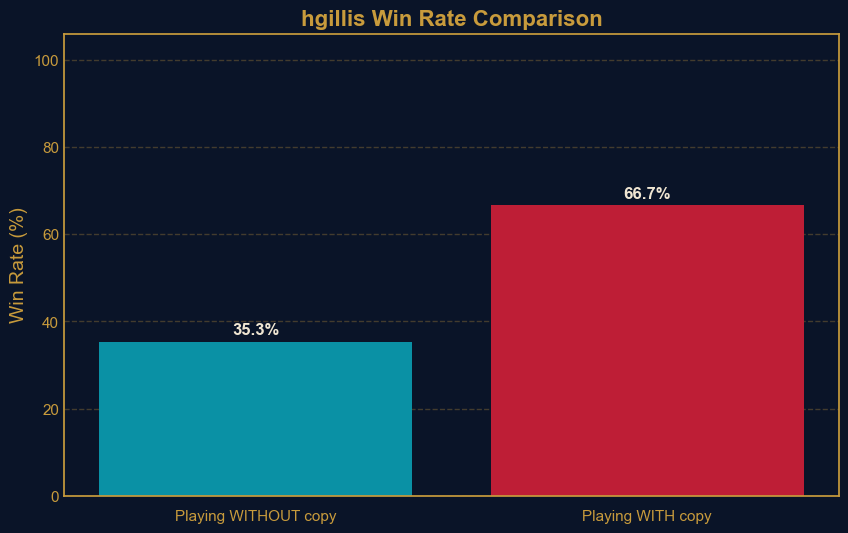

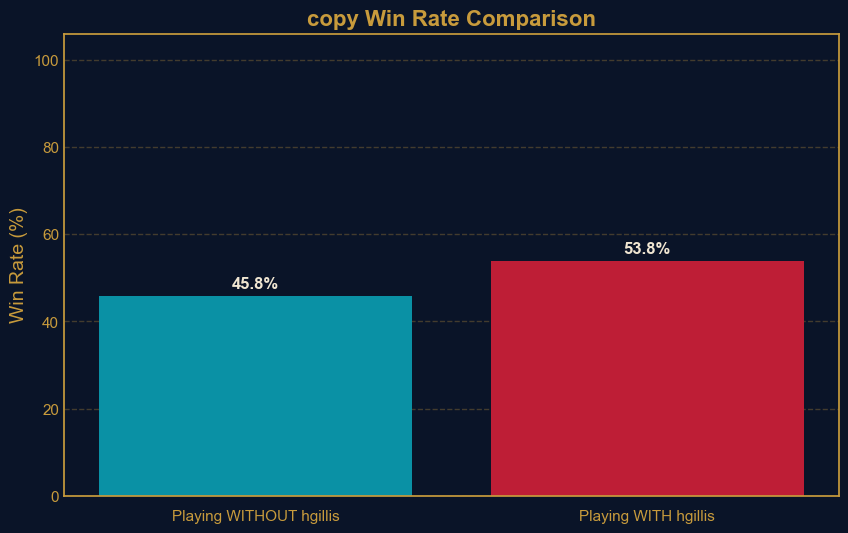

In [24]:


# Set the style of the plots
sns.set(style="whitegrid")

# 1. Win Rate Comparison
def plot_win_rate_comparison(df_solo, df_duo, title, duo_game_name):
    win_rate_solo = df_solo['win'].mean() * 100
    win_rate_duo = df_duo['win'].mean() * 100
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='#0A1428')  # Overall figure background color
    bars = ax.bar(
        x=['Playing WITHOUT ' + duo_game_name, 'Playing WITH ' + duo_game_name],  # Dynamic x-axis labels
        height=[win_rate_solo, win_rate_duo],
        color=['#0A91A5', '#BE1E36'],  # Custom bar colors
        linewidth=0  # Remove the white outline on the bars
    )
    
    # Set Y-axis height limit to 100
    ax.set_ylim(0, 106)
    
    # Add value labels to the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', color='#F0E6D2', weight='bold', fontsize=12)
    
    # Apply League of Legends style colors
    ax.set_title(title, fontsize=16, weight='bold', color='#C89B3C')  # Title in gold
    ax.set_ylabel('Win Rate (%)', fontsize=14, color='#C89B3C')  # Y-axis label in gold
    ax.set_xlabel('', fontsize=12, color='#C89B3C')  # Blank X-axis label, styled in gold
    
    # Set axes background color
    ax.set_facecolor('#0A1428')  # Dark navy axes background
    
    # Customize tick colors
    ax.tick_params(axis='x', colors='#C89B3C')  # X ticks in gold
    ax.tick_params(axis='y', colors='#C89B3C', length=0)  # Y ticks in gold, remove tick marks
    
    # Change spine (border) colors
    for spine in ax.spines.values():
        spine.set_edgecolor('#C89B3C')  # Gold spines (borders)
    
    # Gridlines with subtle opacity
    ax.grid(True, axis = 'y', linestyle='--', alpha=0.3, color='#C89B3C')  # Light gold gridlines
    ax.grid(False, axis='x')
    
    plt.show()

# Usage:
plot_win_rate_comparison(filtered_DfOne_solo, filtered_DfOne_duo, gameNameOne + ' Win Rate Comparison', gameNameTwo)
plot_win_rate_comparison(filtered_DfTwo_solo, filtered_DfTwo_duo, gameNameTwo + ' Win Rate Comparison', gameNameOne)


## Kills

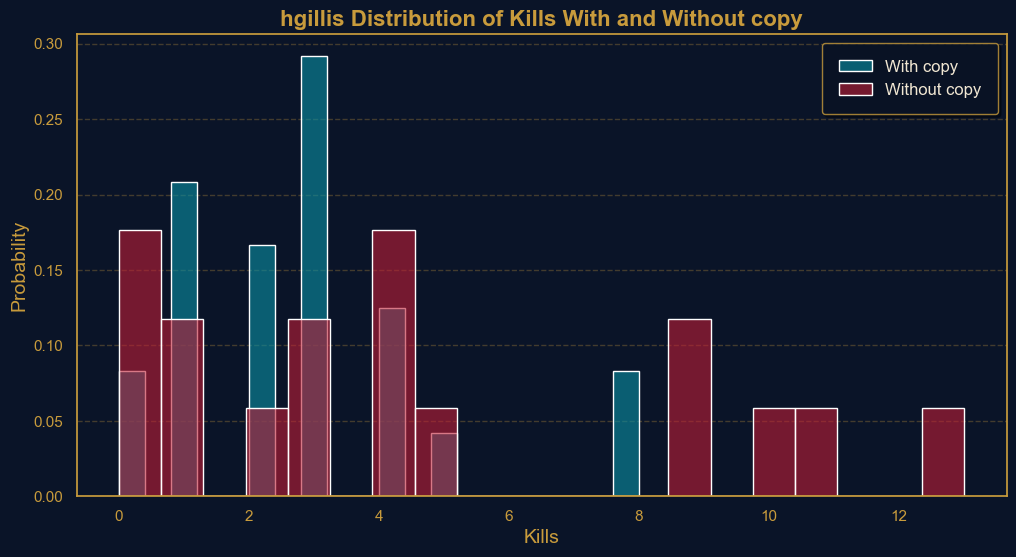

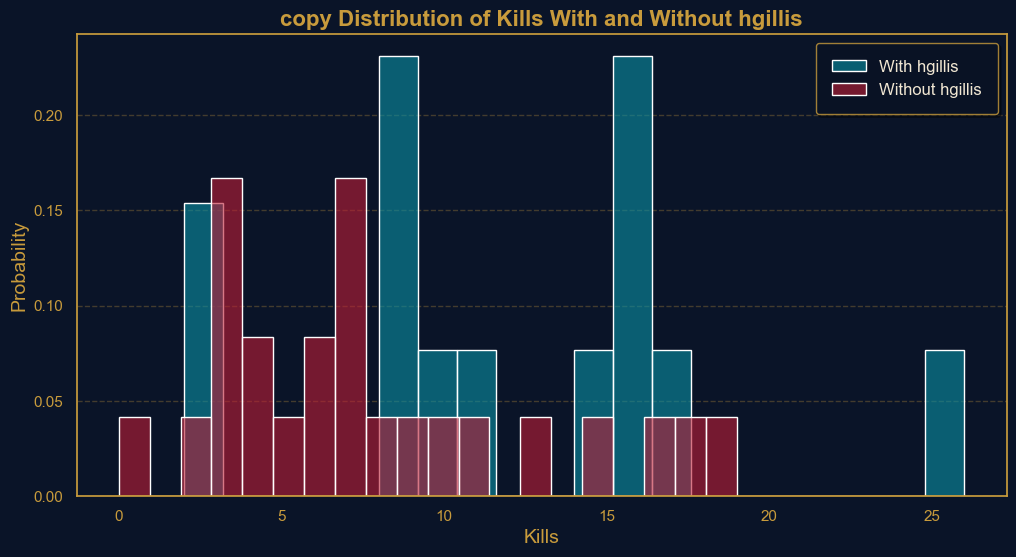

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot distribution of kills with and without a player
def plot_kills_distribution(df_solo, df_duo, title, duo_label):
    # Set the style of the plots
    sns.set(style="whitegrid")
    
    # Plotting
    plt.figure(figsize=(12, 6), facecolor='#0A1428')  # Overall figure background color

    # Histograms with custom colors
    sns.histplot(
        df_duo['kills'], 
        color='#0A91A5', label='With ' + duo_label, 
        kde=False, bins=20, stat="probability", alpha=0.6
    )
    sns.histplot(
        df_solo['kills'], 
        color='#BE1E36', label='Without ' + duo_label, 
        kde=False, bins=20, stat="probability", alpha=0.6
    )

    # Title and labels styled in gold
    plt.title(title, fontsize=16, weight='bold', color='#C89B3C')
    plt.xlabel('Kills', fontsize=14, color='#C89B3C')
    plt.ylabel('Probability', fontsize=14, color='#C89B3C')

    # Legend with text color
    plt.legend(facecolor='#0A1428', edgecolor='#C89B3C', fontsize=12, loc='upper right', 
               title='', title_fontsize='13', framealpha=0.8, shadow=True, borderpad=1, 
               labelcolor='#F0E6D2')  # Change text color to F0E6D2

    # Customize tick colors
    plt.xticks(color='#C89B3C')
    plt.yticks(color='#C89B3C')

    # Gridlines with subtle opacity
    plt.grid(axis='y', linestyle='--', alpha=0.3, color='#C89B3C')
    plt.grid(False, axis='x')

    # Customize spines
    ax = plt.gca()  # Get current axes
    ax.set_facecolor('#0A1428')  # Dark navy axes background
    for spine in ax.spines.values():
        spine.set_edgecolor('#C89B3C')  # Gold spines

    plt.show()

# Usage example:
plot_kills_distribution(filtered_DfOne_solo, filtered_DfOne_duo, gameNameOne + ' Distribution of Kills With and Without ' + gameNameTwo, gameNameTwo)
plot_kills_distribution(filtered_DfTwo_solo, filtered_DfTwo_duo, gameNameTwo + ' Distribution of Kills With and Without ' + gameNameOne, gameNameOne)


## Deaths

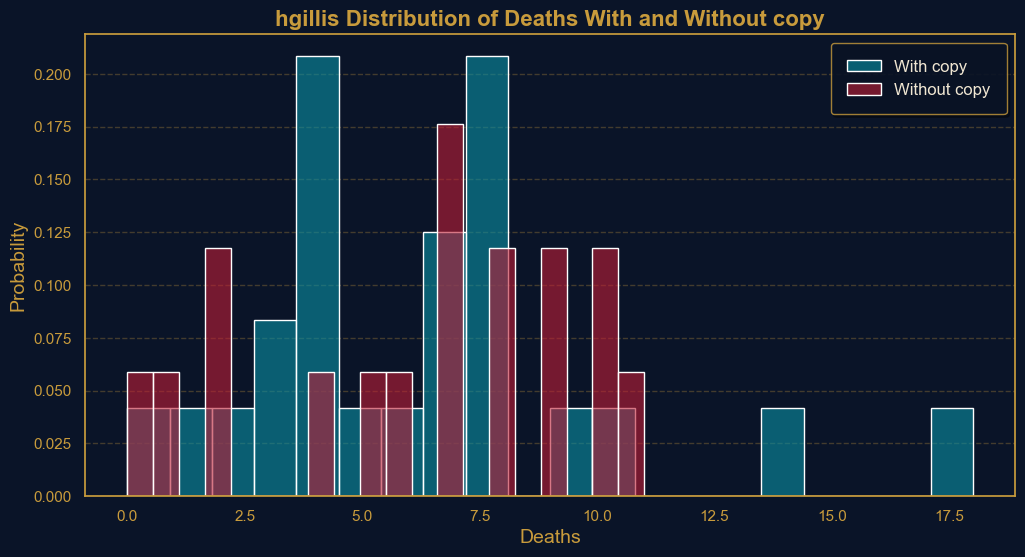

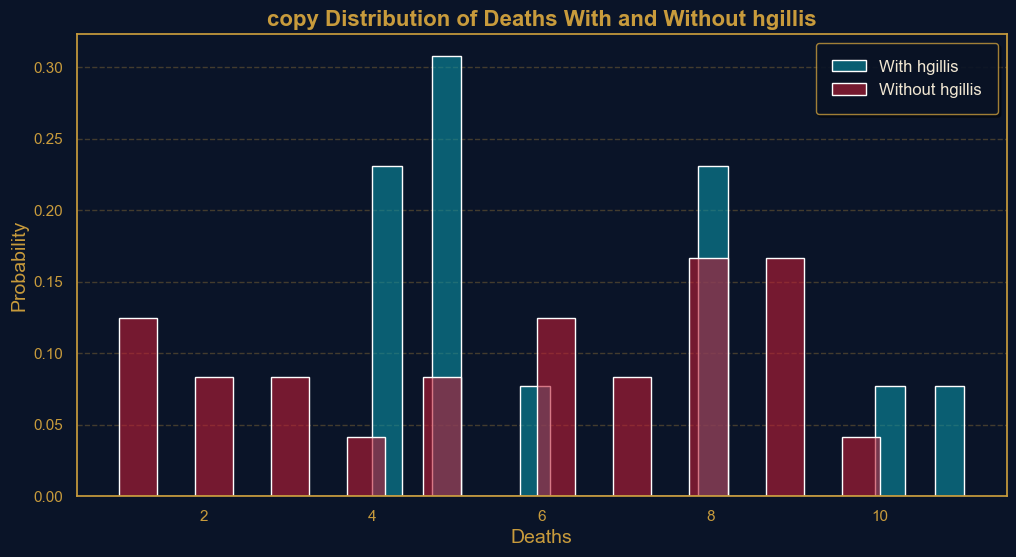

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot distribution of deaths with and without a player
def plot_deaths_distribution(df_solo, df_duo, title, duo_label):
    # Set the style of the plots
    sns.set(style="whitegrid")
    
    # Plotting
    plt.figure(figsize=(12, 6), facecolor='#0A1428')  # Overall figure background color

    # Histograms with custom colors
    sns.histplot(
        df_duo['deaths'], 
        color='#0A91A5', label='With ' + duo_label, 
        kde=False, bins=20, stat="probability", alpha=0.6
    )
    sns.histplot(
        df_solo['deaths'], 
        color='#BE1E36', label='Without ' + duo_label, 
        kde=False, bins=20, stat="probability", alpha=0.6
    )

    # Title and labels styled in gold
    plt.title(title, fontsize=16, weight='bold', color='#C89B3C')
    plt.xlabel('Deaths', fontsize=14, color='#C89B3C')
    plt.ylabel('Probability', fontsize=14, color='#C89B3C')

    # Legend with text color
    plt.legend(facecolor='#0A1428', edgecolor='#C89B3C', fontsize=12, loc='upper right', 
               title='', title_fontsize='13', framealpha=0.8, shadow=True, borderpad=1, 
               labelcolor='#F0E6D2')  # Change text color to F0E6D2

    # Customize tick colors
    plt.xticks(color='#C89B3C')
    plt.yticks(color='#C89B3C')

    # Gridlines with subtle opacity
    plt.grid(axis='y', linestyle='--', alpha=0.3, color='#C89B3C')
    plt.grid(False, axis='x')

    # Customize spines
    ax = plt.gca()  # Get current axes
    ax.set_facecolor('#0A1428')  # Dark navy axes background
    for spine in ax.spines.values():
        spine.set_edgecolor('#C89B3C')  # Gold spines

    plt.show()

# Usage example:
plot_deaths_distribution(filtered_DfOne_solo, filtered_DfOne_duo, gameNameOne + ' Distribution of Deaths With and Without ' + gameNameTwo, gameNameTwo)
plot_deaths_distribution(filtered_DfTwo_solo, filtered_DfTwo_duo, gameNameTwo + ' Distribution of Deaths With and Without ' + gameNameOne, gameNameOne)


## KDA

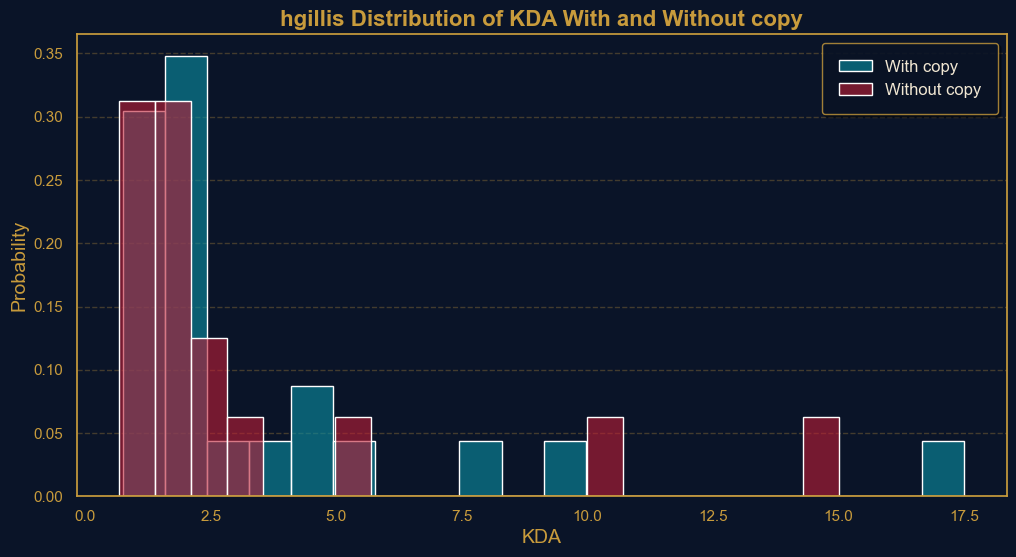

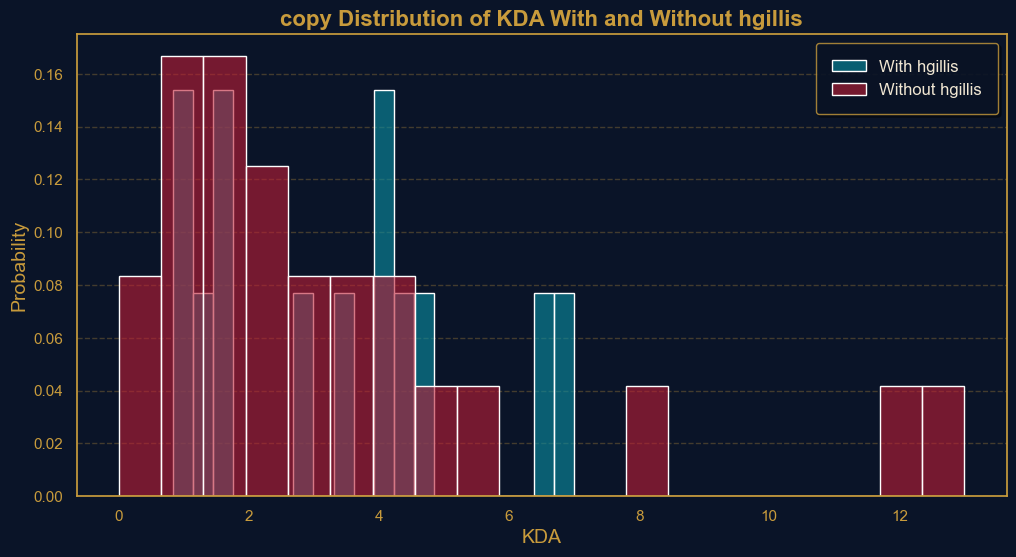

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot distribution of KDA with and without a player
def plot_kda_distribution(df_solo, df_duo, title, duo_label):
    # Set the style of the plots
    sns.set(style="whitegrid")
    
    # Plotting
    plt.figure(figsize=(12, 6), facecolor='#0A1428')  # Overall figure background color

    # Histograms with custom colors
    sns.histplot(
        df_duo['kda'], 
        color='#0A91A5', label='With ' + duo_label, 
        kde=False, bins=20, stat="probability", alpha=0.6
    )
    sns.histplot(
        df_solo['kda'], 
        color='#BE1E36', label='Without ' + duo_label, 
        kde=False, bins=20, stat="probability", alpha=0.6
    )

    # Title and labels styled in gold
    plt.title(title, fontsize=16, weight='bold', color='#C89B3C')
    plt.xlabel('KDA', fontsize=14, color='#C89B3C')
    plt.ylabel('Probability', fontsize=14, color='#C89B3C')

    # Legend with text color
    plt.legend(facecolor='#0A1428', edgecolor='#C89B3C', fontsize=12, loc='upper right', 
               title='', title_fontsize='13', framealpha=0.8, shadow=True, borderpad=1, 
               labelcolor='#F0E6D2')  # Change text color to F0E6D2

    # Customize tick colors
    plt.xticks(color='#C89B3C')
    plt.yticks(color='#C89B3C')

    # Gridlines with subtle opacity
    plt.grid(axis='y', linestyle='--', alpha=0.3, color='#C89B3C')
    plt.grid(False, axis='x')

    # Customize spines
    ax = plt.gca()  # Get current axes
    ax.set_facecolor('#0A1428')  # Dark navy axes background
    for spine in ax.spines.values():
        spine.set_edgecolor('#C89B3C')  # Gold spines

    plt.show()

# Usage example:
plot_kda_distribution(filtered_DfOne_solo, filtered_DfOne_duo, gameNameOne + ' Distribution of KDA With and Without ' + gameNameTwo, gameNameTwo)
plot_kda_distribution(filtered_DfTwo_solo, filtered_DfTwo_duo, gameNameTwo + ' Distribution of KDA With and Without ' + gameNameOne, gameNameOne)


## Load Times

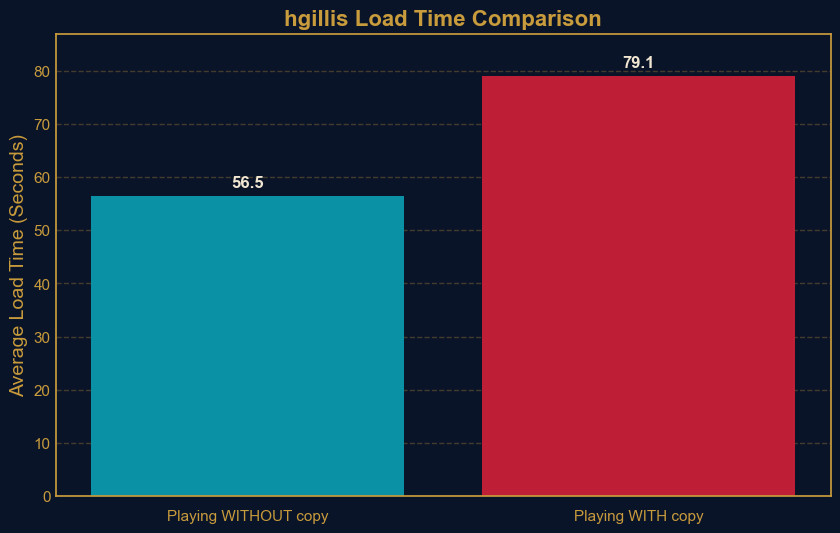

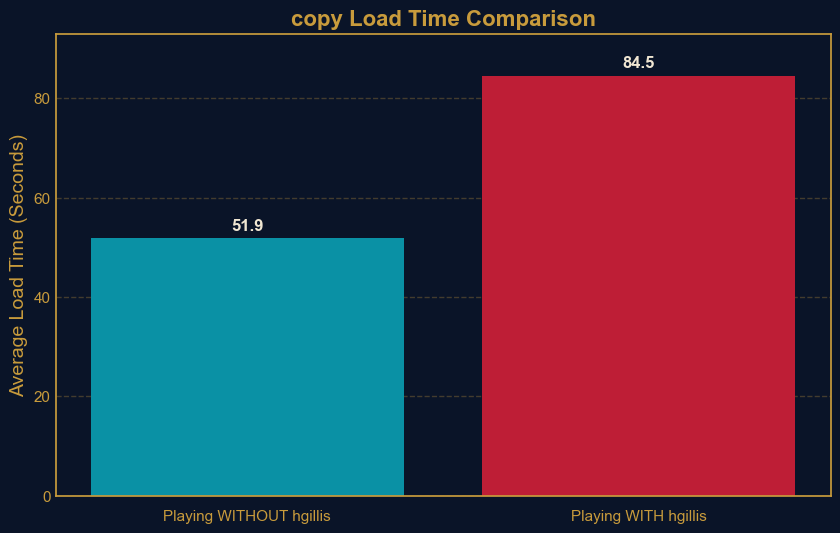

In [28]:
# Modified plot function for 'loadTime'
def plot_load_time_comparison(df_solo, df_duo, title, duo_game_name):
    load_time_solo = df_solo['loadTime'].mean()  # Average loadTime for solo
    load_time_duo = df_duo['loadTime'].mean()  # Average loadTime for duo
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='#0A1428')  # Overall figure background color
    bars = ax.bar(
        x=['Playing WITHOUT ' + duo_game_name, 'Playing WITH ' + duo_game_name],  # Dynamic x-axis labels
        height=[load_time_solo, load_time_duo],
        color=['#0A91A5', '#BE1E36'],  # Custom bar colors
        linewidth=0  # Remove the white outline on the bars
    )
    
    # Set Y-axis height limit to a reasonable range
    ax.set_ylim(0, max(load_time_solo, load_time_duo) * 1.1)
    
    # Add value labels to the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, yval + 1, f'{yval:.1f}', ha='center', va='bottom', color='#F0E6D2', weight='bold', fontsize=12)
    
    # Apply League of Legends style colors
    ax.set_title(title, fontsize=16, weight='bold', color='#C89B3C')  # Title in gold
    ax.set_ylabel('Average Load Time (Seconds)', fontsize=14, color='#C89B3C')  # Y-axis label in gold
    ax.set_xlabel('', fontsize=12, color='#C89B3C')  # Blank X-axis label, styled in gold
    
    # Set axes background color
    ax.set_facecolor('#0A1428')  # Dark navy axes background
    
    # Customize tick colors
    ax.tick_params(axis='x', colors='#C89B3C')  # X ticks in gold
    ax.tick_params(axis='y', colors='#C89B3C', length=0)  # Y ticks in gold, remove tick marks
    
    # Change spine (border) colors
    for spine in ax.spines.values():
        spine.set_edgecolor('#C89B3C')  # Gold spines (borders)
    
    # Gridlines with subtle opacity
    ax.grid(True, axis = 'y', linestyle='--', alpha=0.3, color='#C89B3C')  # Light gold gridlines
    ax.grid(False, axis='x')
    
    plt.show()

# Usage:
plot_load_time_comparison(filtered_DfOne_solo, filtered_DfOne_duo, gameNameOne + ' Load Time Comparison', gameNameTwo)
plot_load_time_comparison(filtered_DfTwo_solo, filtered_DfTwo_duo, gameNameTwo + ' Load Time Comparison', gameNameOne)
